In [1]:
import os
from pathlib import Path
import sys

# set working directory to the module's home
cwd = os.getcwd()
os.chdir(Path(cwd).parents[1])

In [2]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from config import connect
from db_management.database_management import load_data
from modeling.time_series_forecast import TimeSeriesForecaster

### Connect to MySQL Database `AQI` for the Table `combined`

In [3]:
conn = connect()
cursor = conn.cursor()

In [4]:
df = load_data(conn, "AQI", "index", "SELECT * FROM AQI.index WHERE state_name='Georgia' AND county_name='Fulton'")
df.head()

,state_name,date,aqi,category,defining_parameter,latitude,longitude,county_name
0,Georgia,2021-01-01,28,Good,PM2.5,33.7784,-84.3914,Fulton
1,Georgia,2021-01-02,38,Good,PM2.5,33.7784,-84.3914,Fulton
2,Georgia,2021-01-03,28,Good,NO2,33.7784,-84.3914,Fulton
3,Georgia,2021-01-04,30,Good,PM2.5,33.7784,-84.3914,Fulton
4,Georgia,2021-01-05,35,Good,PM2.5,33.7784,-84.3914,Fulton


In [5]:
tsf = TimeSeriesForecaster()

In [6]:
tsf.fit(df, "date", "aqi", "MS", "mean")

In [7]:
fcst = tsf.forecast(periods=120)
fcst

,date,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,aqi
0,1980-01-01,50.491419,24.411171,58.070055,47.458774,53.652912,-0.183785,-0.244109,-0.125465,-0.183785,-0.244109,-0.125465,0.0,0.0,0.0,41.211850,57.451613
1,1980-02-01,50.630266,26.055421,59.133195,47.658541,53.714719,-0.153873,-0.209160,-0.101348,-0.153873,-0.209160,-0.101348,0.0,0.0,0.0,42.839646,57.206897
2,1980-03-01,50.760155,26.042121,59.318820,47.836525,53.768263,-0.159717,-0.211104,-0.108771,-0.159717,-0.211104,-0.108771,0.0,0.0,0.0,42.652908,45.838710
3,1980-04-01,50.899002,29.889691,62.310359,48.031221,53.828612,-0.086218,-0.144182,-0.021848,-0.086218,-0.144182,-0.021848,0.0,0.0,0.0,46.510613,49.566667
4,1980-05-01,51.033370,39.511908,73.594600,48.202023,53.907870,0.097001,0.030134,0.158161,0.097001,0.030134,0.158161,0.0,0.0,0.0,55.983636,50.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,2030-11-01,29.095451,6.211009,41.940762,20.737547,37.624608,-0.163308,-0.209951,-0.117174,-0.163308,-0.209951,-0.117174,0.0,0.0,0.0,24.343946,NaN
611,2030-12-01,28.978747,5.878782,41.791036,20.475914,37.597944,-0.190952,-0.237508,-0.142172,-0.190952,-0.237508,-0.142172,0.0,0.0,0.0,23.445196,NaN
612,2031-01-01,28.858153,5.791243,41.001190,20.261953,37.496737,-0.180146,-0.225647,-0.137356,-0.180146,-0.225647,-0.137356,0.0,0.0,0.0,23.659467,NaN
613,2031-02-01,28.737559,6.130443,42.061046,20.062248,37.465937,-0.178828,-0.221530,-0.137661,-0.178828,-0.221530,-0.137661,0.0,0.0,0.0,23.598483,NaN


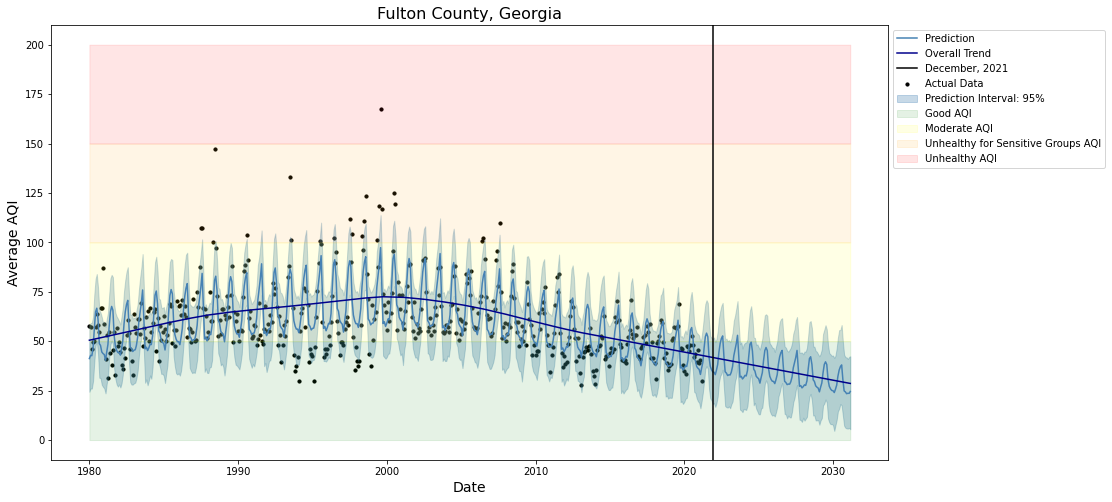

In [8]:
fig, ax = tsf.plot_forecast()
ax.fill_between(x=fcst.date, y1=0, y2=50, alpha=0.1, color="green", label="Good AQI")
ax.fill_between(x=fcst.date, y1=50, y2=100, alpha=0.1, color="yellow", label="Moderate AQI")
ax.fill_between(x=fcst.date, y1=100, y2=150, alpha=0.1, color="orange", label="Unhealthy for Sensitive Groups AQI")
ax.fill_between(x=fcst.date, y1=150, y2=200, alpha=0.1, color="red", label="Unhealthy AQI")
plt.axvline(x=pd.to_datetime("2021-12-01"), c="k", label="December, 2021")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Fulton County, Georgia", fontsize=16)
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Average AQI", fontsize=14)
plt.show()

In [9]:
df.groupby(by="category").agg({"aqi":["min", "max"]}).sort_values(('aqi', 'min'))

aqi     
                                min  max
category                                
Good                              1   50
Moderate                         51  100
Unhealthy for Sensitive Groups  101  150
Unhealthy                       151  200
Very Unhealthy                  201  249